In [7]:
import tables
import os

filename = '/home/tirocinio/Codice/tirocinio/Dati/DL0/acquisizione_2023_01_27/rpg0/dl0/wf_runId_00293_configId_00000_2023-01-27T14_32_51.090204.h5'

class Reader:
    def get_data_list(self,filename,startIndex=0,endIndex=-1):
        '''get data from h5 file starting by startIndex and ending at endIndex
        '''
        data_list = []
        with tables.open_file(filename,mode='r') as h5file:
            group = h5file.get_node('/waveforms')
            if endIndex == -1:
                endIndex = group._g_getnchildren()
            for i,data in enumerate(group):
                if i >= startIndex:
                    arr = data[:,-1]
                    data_list.append(arr)
                if i>=endIndex-1:
                    break
            return data_list
        
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"La directory '{directory_path}' è stata creata.")

In [8]:
reader = Reader()
data = reader.get_data_list(filename,0,200)

In [9]:
len(data[0])

16384

In [10]:
print(data[0:3])

[array([131, 134, 126, ..., 129, 127, 130], dtype=int16), array([130, 128, 135, ..., 130, 131, 137], dtype=int16), array([126, 131, 127, ..., 132, 135, 125], dtype=int16)]


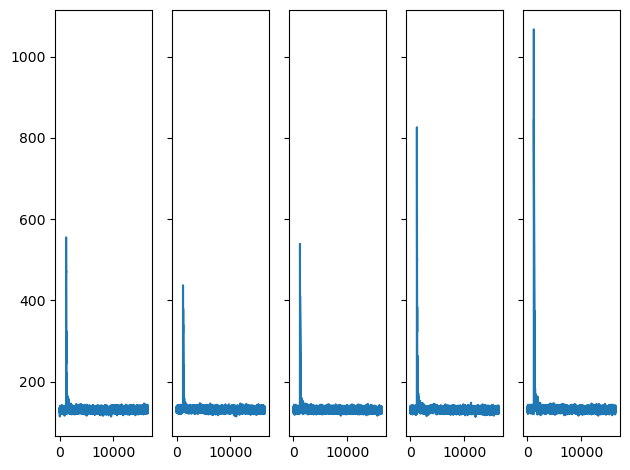

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, sharey=True, tight_layout=True)
for i in range(5):
    #print(len(data[i]))
    axs[i].plot(data[i])

268033


/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:62: RuntimeWarning: overflow encountered in exp
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))
/home/tirocinio/Codice/tirocinio/BBexponential/bb_exponential.py:62: RuntimeWarning: invalid value encountered in divide
  Q_k = np.exp(-a*T_k)/(1-np.exp(-a*T_k))


Tempo di Calcolo: 2.3306875228881836
Estremi: [  0. 999.]
Blocco 0: a=nan,gamma=nan


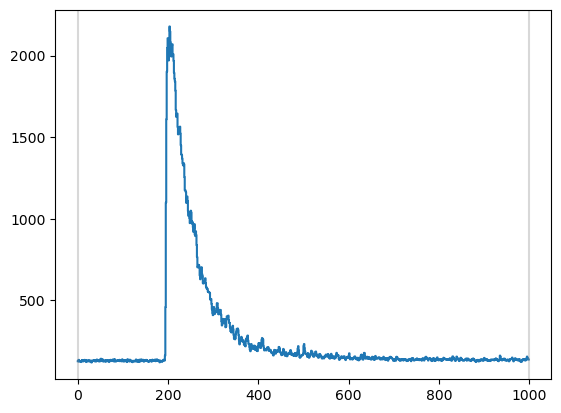

In [12]:
from astropy.stats import Events, bayesian_blocks
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp
t=np.arange(0,1000)
x=data[188][1000:2000]
print(sum(x))
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=1600)

In [8]:
from astropy.stats import Events, bayesian_blocks
import numpy as np
from bb_exponential import ExponentialBlocks_Events, test_bb_exp

In [ ]:
t=np.arange(0,1000)
for i in range(50,len(data)):
    x=data[i][1000:2000]
    test_bb_exp(t,x,ExponentialBlocks_Events,save = False,name=f'outdir/wf_runId_00293_configId_00000_2023-01-27T14_32_51_090204_datanum_{i}.png',ncp_prior=800)

Tempo di Calcolo: 0.28838396072387695
Estremi: [ 0. 14.]
Blocco 0: a=0.6663241752908087,gamma=21835.38436940294


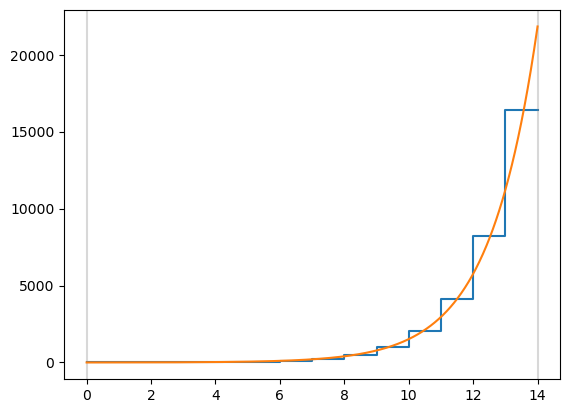

In [10]:
t=np.arange(0,15)
x=np.floor(np.power(2,t))
test_bb_exp(t,x,ExponentialBlocks_Events,ncp_prior=100000)